Kutay'ın Burak'ın yaklaşımına yaklaşımı

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import qmc
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

1st try

Points with the highest scores: [[ 29.62879304 -59.3709541 ]
 [ 61.89356324  76.97083628]
 [ -7.26340787 135.33646892]]
Iteration 1, RMSE: 43.98942977801217
Points with the highest scores: [[-26.09615962 -22.27224741]
 [ -0.75776112  67.71991216]
 [  5.63688134 105.00493044]]
Iteration 2, RMSE: 30.281823366338923
Points with the highest scores: [[ -8.77460008 -41.20826925]
 [ 15.34151566 -33.75615201]
 [-30.78964527  -4.10774719]]
Iteration 3, RMSE: 30.844072148159313
Convergence reached at iteration 3.


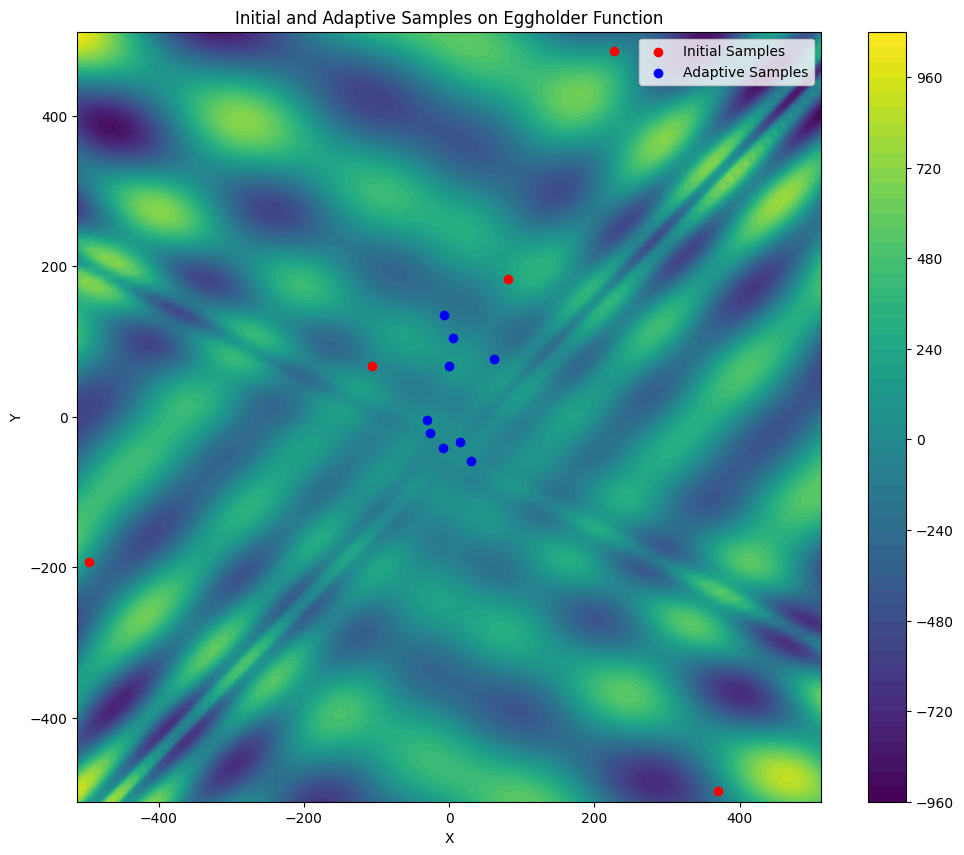

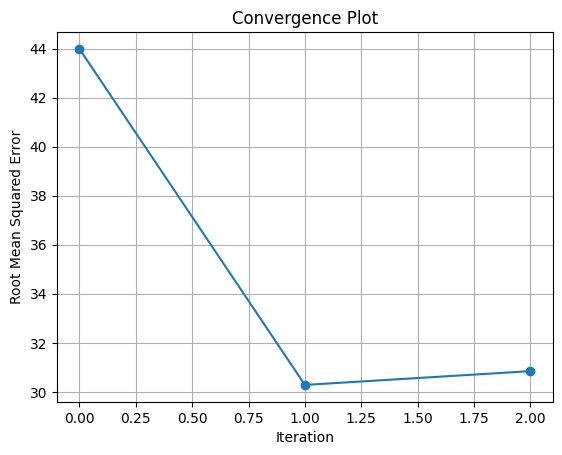

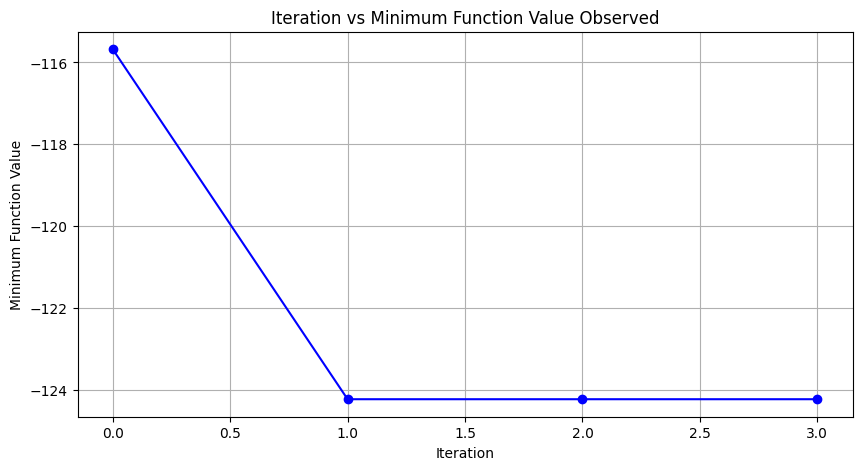

Best observed function value after active learning: -124.2352986462239


,X1,X2
0,-496.285769,-193.010580
1,226.341529,486.777113
2,-106.814117,67.715392
3,370.312961,-498.174239
4,80.547909,183.304255
5,29.628793,-59.370954
6,61.893563,76.970836
7,-7.263408,135.336469
8,-26.096160,-22.272247
9,-0.757761,67.719912


In [2]:
# Define the Eggholder function
def eggholder_function(x, y):
    term1 = -(y + 47) * np.sin(np.sqrt(abs(x / 2 + (y + 47))))
    term2 = -x * np.sin(np.sqrt(abs(x - (y + 47))))
    return term1 + term2

# Function to calculate Euclidean distance between two points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Generate a mesh for the background Eggholder function
x = np.linspace(-512, 512, 100)
y = np.linspace(-512, 512, 100)
X, Y = np.meshgrid(x, y)
Z = eggholder_function(X, Y)

# Sample initial points using Latin hypercube sampling
lhs = qmc.LatinHypercube(d=2)
initial_samples = lhs.random(n=5)
initial_points = qmc.scale(initial_samples, [-512, -512], [512, 512])
initial_values = np.array([eggholder_function(x, y) for x, y in initial_points])


# Train the initial Random Forest model
rf = RandomForestRegressor(n_estimators=10, random_state=1729)
rf.fit(initial_points, initial_values)

# Active learning loop for optimization with adaptive sampling
num_iterations = 1000
tolerance = 5
improvement = []

min_function_values = [np.min(initial_values)]  # Track min function value for each iteration

# Calculate the sum of the maximum distance from each point in new_points to any point in initial_points
max_distance_sums = np.zeros(len(initial_points))

samples = initial_points
sample_values = initial_values


# Perform active learning with adaptive sampling
for iteration in range(num_iterations):
    # Generate new candidate samples using LHS
    new_samples_lhs = lhs.random(n=60)  # Increased number of samples to ensure enough points to choose from
    new_points = qmc.scale(new_samples_lhs, [-512, -512], [512, 512])

    # Calculate the distances from each new point to all existing points
    distances_to_existing_points = np.zeros((len(new_points), len(samples)))
    for i, new_point in enumerate(new_points):
        for j, existing_point in enumerate(samples):
            distances_to_existing_points[i, j] = euclidean_distance(new_point, existing_point)

    # Calculate scores based on the average distance to existing points
    avg_distances_to_existing_points = np.mean(distances_to_existing_points, axis=1)
    scores = 1 / (avg_distances_to_existing_points + 1)  # Adding 1 to avoid division by zero

    # Find the indices of the points with the highest scores
    indices_of_highest_scores = np.argsort(scores)[-3:]  # Select the indices of top 3 points

    # The points with the highest scores
    chosen_new_points = new_points[indices_of_highest_scores]

    print("Points with the highest scores:", chosen_new_points)

    # Update the model with the new points
    chosen_new_values = np.array([eggholder_function(point[0], point[1]) for point in chosen_new_points])

    # Update training data
    new_points_all = np.vstack([samples, chosen_new_points])
    new_values_all = np.append(sample_values, chosen_new_values)

    # Sort the values in descending order
    new_values_all.sort()

    # Keep track of the minimum function value observed so far
    min_function_values.append(np.min(np.hstack((initial_values, new_values_all))))

    # Re-fit the model including the new points
    rf.fit(new_points_all, new_values_all)

    # Calculate improvement
    rmse = (mean_squared_error(new_values_all, rf.predict(new_points_all))) ** 0.5
    improvement.append(rmse)

    print(f"Iteration {iteration + 1}, RMSE: {rmse}")

    # Check for convergence (change in func value less than the tolerance)
    if len(improvement) > 1 and abs(improvement[-2] - improvement[-1]) <= tolerance:
        print(f"Convergence reached at iteration {iteration + 1}.")
        break

    # Update the sample points and values for the next iteration
    samples = new_points_all
    sample_values = new_values_all


# Plot initial and final samples
plt.figure(figsize=(12, 10))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar()
plt.scatter(initial_points[:,0], initial_points[:, 1], c='red', label='Initial Samples')
plt.scatter(new_points_all[5:, 0], new_points_all[5:, 1], c='blue', label='Adaptive Samples')
plt.legend()
plt.title('Initial and Adaptive Samples on Eggholder Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plot convergence over iterations
plt.figure()
plt.plot(range(len(improvement)), improvement, marker='o')
plt.title('Convergence Plot')
plt.xlabel('Iteration')
plt.ylabel('Root Mean Squared Error')
plt.grid(True)
plt.show()

# Plot iteration vs minimum function values observed
plt.figure(figsize=(10, 5))
plt.plot(min_function_values, marker='o', linestyle='-', color='blue')
plt.title('Iteration vs Minimum Function Value Observed')
plt.xlabel('Iteration')
plt.ylabel('Minimum Function Value')
plt.grid(True)
plt.show()

# Print final result
print(f"Best observed function value after active learning: {min(min_function_values)}")

samples_df = pd.DataFrame({"X1":new_points_all[:,0], "X2":new_points_all[:,1]})
samples_df

2nd try

Points with the highest scores: [[ 54.69273323 -66.35681755]
 [ -9.90430105 106.27426513]
 [-42.84700532  38.37622526]]
Iteration 1, RMSE: 80.74105529602699
Points with the highest scores: [[ 27.87582209 -20.9813557 ]
 [-18.73575348  61.16337959]
 [-10.51219706  19.77458162]]
Iteration 2, RMSE: 73.88666012279027
Points with the highest scores: [[ -57.22131745 -101.49182205]
 [-104.10547084   15.66047008]
 [ -22.00059622  -39.31008484]]
Iteration 3, RMSE: 42.41328289477471
Points with the highest scores: [[ 35.22940366 -93.71399484]
 [ 63.72158361 -54.49743754]
 [ 17.26319013  84.73706331]]
Iteration 4, RMSE: 100.97252597262407
Points with the highest scores: [[ 111.59718481  -96.68090922]
 [-117.92732832   48.21707705]
 [ -75.18368573 -103.01450142]]
Iteration 5, RMSE: 40.558836782017984
Points with the highest scores: [[116.21821379  82.08001433]
 [ 37.64897995  40.01262716]
 [-53.82158026 -66.80939057]]
Iteration 6, RMSE: 79.00337536576589
Points with the highest scores: [[-71.831774

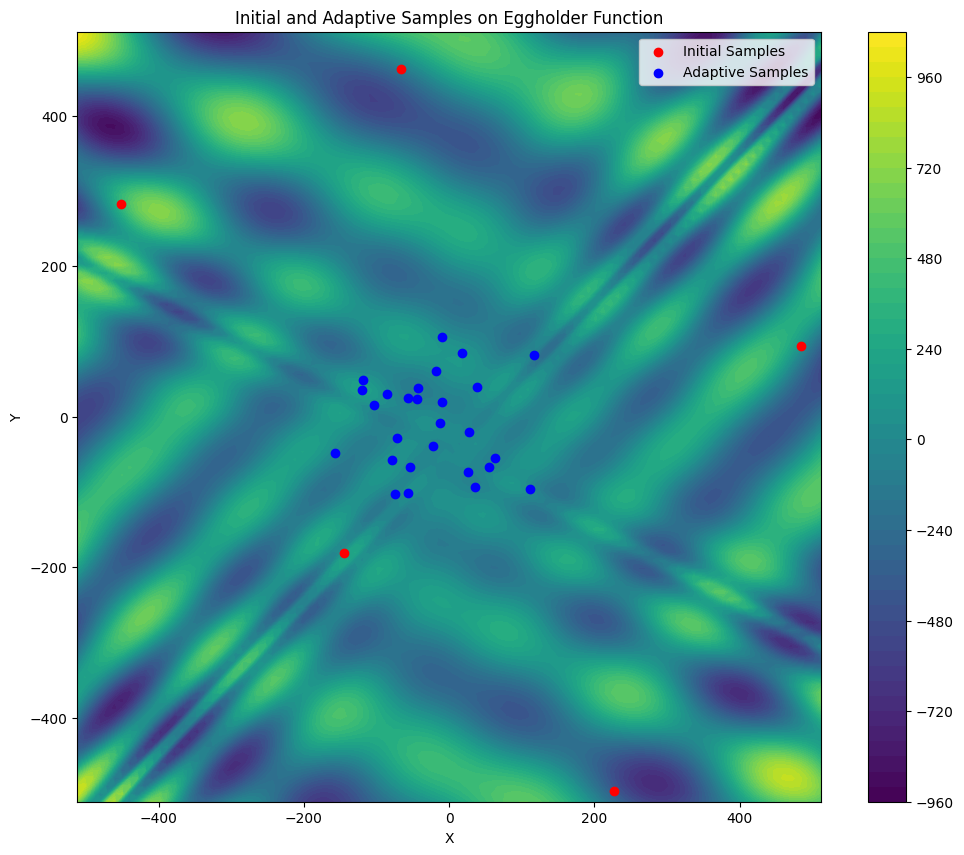

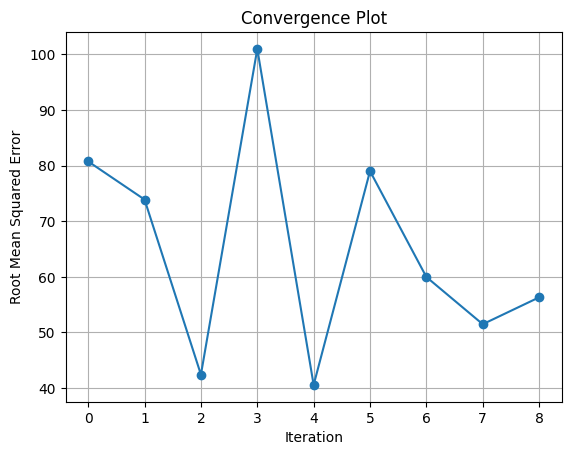

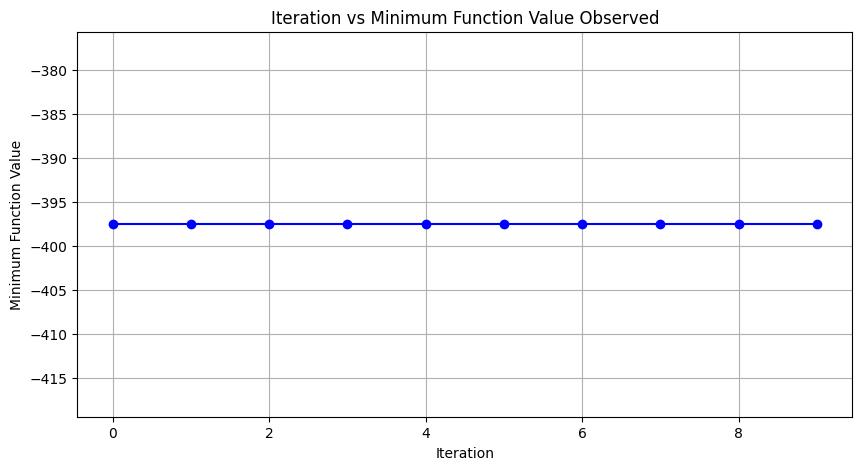

Best observed function value after active learning: -397.49145301876933


In [3]:
# Define the Eggholder function
def eggholder_function(x, y):
    term1 = -(y + 47) * np.sin(np.sqrt(abs(x / 2 + (y + 47))))
    term2 = -x * np.sin(np.sqrt(abs(x - (y + 47))))
    return term1 + term2

# Function to calculate Euclidean distance between two points
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Generate a mesh for the background Eggholder function
x = np.linspace(-512, 512, 100)
y = np.linspace(-512, 512, 100)
X, Y = np.meshgrid(x, y)
Z = eggholder_function(X, Y)

# Sample initial points using Latin hypercube sampling
lhs = qmc.LatinHypercube(d=2)
initial_samples = lhs.random(n=5)
initial_points = qmc.scale(initial_samples, [-512, -512], [512, 512])
initial_values = np.array([eggholder_function(x, y) for x, y in initial_points])


# Train the initial Random Forest model
rf = RandomForestRegressor(n_estimators=10, random_state=1729)
rf.fit(initial_points, initial_values)

# Active learning loop for optimization with adaptive sampling
num_iterations = 1000
tolerance = 5
improvement = []

min_function_values = [np.min(initial_values)]  # Track min function value for each iteration

# Calculate the sum of the maximum distance from each point in new_points to any point in initial_points
max_distance_sums = np.zeros(len(initial_points))

samples = initial_points
sample_values = initial_values


for iteration in range(num_iterations):
    # Generate new candidate samples using LHS
    new_samples_lhs = lhs.random(n=60)  # Increased number of samples to ensure enough points to choose from
    new_points = qmc.scale(new_samples_lhs, [-512, -512], [512, 512])

    # Train the model with existing samples
    rf.fit(samples, sample_values)

    # Update the model with the newly generated points
    new_values = np.array([eggholder_function(point[0], point[1]) for point in new_points])
    all_points = np.vstack([samples, new_points])
    all_values = np.hstack([sample_values, new_values])
    rf.fit(all_points, all_values)

    # Calculate the distances from each new point to existing samples
    distances_to_existing_points = np.zeros((len(new_points), len(samples)))
    for i, new_point in enumerate(new_points):
        for j, sample_point in enumerate(samples):
            distances_to_existing_points[i, j] = euclidean_distance(new_point, sample_point)

    # Calculate scores based on the average distance to existing samples
    avg_distances_to_existing_points = np.mean(distances_to_existing_points, axis=1)
    scores = 1 / (avg_distances_to_existing_points + 1)  # Adding 1 to avoid division by zero

    # Find the indices of the points with the highest scores
    indices_of_highest_scores = np.argsort(scores)[-3:]  # Select the indices of top 3 points

    # The points with the highest scores
    chosen_new_points = new_points[indices_of_highest_scores]

    print("Points with the highest scores:", chosen_new_points)

    # Update the sample points and values for the next iteration
    samples = np.vstack([samples, chosen_new_points])
    sample_values = np.append(sample_values, [eggholder_function(point[0], point[1]) for point in chosen_new_points])

    # Keep track of the minimum function value observed so far
    min_function_values.append(np.min(sample_values))

    # Calculate improvement
    rmse = (mean_squared_error(sample_values, rf.predict(samples))) ** 0.5
    improvement.append(rmse)

    print(f"Iteration {iteration + 1}, RMSE: {rmse}")

    # Check for convergence (change in func value less than the tolerance)
    if len(improvement) > 1 and abs(improvement[-2] - improvement[-1]) <= tolerance:
        print(f"Convergence reached at iteration {iteration + 1}.")
        break

# Plot initial and final samples
plt.figure(figsize=(12, 10))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar()
plt.scatter(initial_points[:, 0], initial_points[:, 1], c='red', label='Initial Samples')
plt.scatter(samples[5:, 0], samples[5:, 1], c='blue', label='Adaptive Samples')  # Changed to use 'samples'
plt.legend()
plt.title('Initial and Adaptive Samples on Eggholder Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plot convergence over iterations
plt.figure()
plt.plot(range(len(improvement)), improvement, marker='o')
plt.title('Convergence Plot')
plt.xlabel('Iteration')
plt.ylabel('Root Mean Squared Error')
plt.grid(True)
plt.show()

# Plot iteration vs minimum function values observed
plt.figure(figsize=(10, 5))
plt.plot(min_function_values, marker='o', linestyle='-', color='blue')
plt.title('Iteration vs Minimum Function Value Observed')
plt.xlabel('Iteration')
plt.ylabel('Minimum Function Value')
plt.grid(True)
plt.show()

# Print final result
print(f"Best observed function value after active learning: {min(min_function_values)}")

samples_df = pd.DataFrame({"X1": samples[:, 0], "X2": samples[:, 1]})  # Changed to use 'samples'